In [1]:
import numpy as np

import lunar_lander
from turbo_test import demo_heuristic_lander
import tensorflow as tf
import tensorflow_probability as tfp
import trieste

import timeit

2021-12-03 14:14:29.046539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 14:14:29.046557: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-03 14:14:30.166876: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-03 14:14:30.187869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 14:14:30.188133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.683GHz coreCount: 15 deviceMemorySize: 7.93GiB devi

In [2]:
# this space is created by going approximately +-0.2 around parameter values, but not going below 0
# see for original values https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py
# original values are
# 0.5 1 0.4 0.55 0.5 1 0.5 0.5 0 0.5 0.05 0.05
# and for parameter definition https://github.com/uber-research/TuRBO
search_space = trieste.space.Box(
    [0.3, 0.8, 0.2, 0.35, 0.3, 0.8, 0.3, 0.3, 0.0, 0.3, 0.0,  0.0],
    [0.7, 1.2, 0.6, 0.75, 0.7, 1.2, 0.7, 0.7, 0.2, 0.7, 0.25, 0.25]
)

In [3]:
OBJECTIVE = trieste.observer.OBJECTIVE
# lander crashed or timed out
FAILURE = "FAILURE"

create_empty_dataset = lambda : trieste.data.Dataset(
                                    tf.zeros((0, search_space.dimension), tf.float64),
                                    tf.zeros((0, 1), tf.float64)
                                )

def lander_observer(x):
    all_datasets = {
        OBJECTIVE: create_empty_dataset(),
        FAILURE: create_empty_dataset()
    }

    def add_data(dataset_tag, x, y):
        new_dataset = trieste.data.Dataset(np.atleast_2d(x), np.atleast_2d(y))
        all_datasets[dataset_tag] += new_dataset

    for w in x.numpy():
        result = demo_heuristic_lander(lunar_lander.LunarLander(), w)
        if result.timeout or result.has_crashed:
            add_data(FAILURE, w, 0.0)
            continue
        else:
            add_data(FAILURE, w, 1.0)

        normalized_fuel = np.float64(result.total_fuel / 100.0)
        add_data(OBJECTIVE, w, normalized_fuel)
    
    return all_datasets

In [4]:
num_initial_points = 1
initial_query_points = search_space.sample(1)
initial_data = lander_observer(initial_query_points)

# collect points until we have at least one in each dataset
while any(len(initial_data[tag]) < search_space.dimension for tag in initial_data):
    initial_query_points = search_space.sample(1)
    new_initial_data = lander_observer(initial_query_points)
    for tag in initial_data:
        initial_data[tag] = initial_data[tag] + new_initial_data[tag]
    num_initial_points += 1

DemoHeuristicResult: reward: -63.77, fuel: 14.61, steps: 91.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 289.82, fuel: 30.21, steps: 256.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 274.44, fuel: 32.70, steps: 436.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 20.55, fuel: 15.69, steps: 102.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 201.28, fuel: 44.94, steps: 406.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 76.92, fuel: 31.80, steps: 159.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 22.17, fuel: 12.18, steps: 104.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -43.13, fuel: 10.62, steps: 84.0, crashed: True, timeou

In [5]:
print(len(initial_data[OBJECTIVE]))
print(len(initial_data[FAILURE]))

12
50


In [6]:
import gpflow


def create_regression_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance, lengthscales=[0.2]*int(search_space.dimension))
    scale = tf.constant(1.0, dtype=tf.float64)
    kernel.variance.prior = tfp.distributions.LogNormal(
        tf.constant(-2.0, dtype=tf.float64), scale
    )
    kernel.lengthscales.prior = tfp.distributions.LogNormal(
        tf.math.log(kernel.lengthscales), scale
    )
    gpr = gpflow.models.GPR(data.astuple(), kernel)
    return gpr


def create_classification_model(data):
    kernel = gpflow.kernels.SquaredExponential(
        lengthscales=[0.2]*int(search_space.dimension)
    )
    likelihood = gpflow.likelihoods.Bernoulli()
    vgp = gpflow.models.VGP(data.astuple(), kernel, likelihood)
    return vgp

from trieste.models.gpflow import GPflowModelConfig

classification_model_config_args = {
    "model_args": {"use_natgrads": True},
    "optimizer": tf.optimizers.Adam(1e-3),
    "optimizer_args": {"max_iter": 50},
}
models = {
    OBJECTIVE: GPflowModelConfig(**{
        "model": create_regression_model(initial_data[OBJECTIVE]),
        "optimizer": gpflow.optimizers.Scipy(),
    }),
    FAILURE: GPflowModelConfig(
        create_classification_model(initial_data[FAILURE]),
        **classification_model_config_args
    )
}

In [7]:
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.acquisition import (
    SingleModelAcquisitionBuilder
)
from hacks import HackedExpectedConstrainedImprovement, HackedLocalPenalizationAcquisitionFunction

BATCH_SIZE = 10
ITERATIONS = 10

class ProbabilityOfValidity(SingleModelAcquisitionBuilder):
    def prepare_acquisition_function(self, model, dataset=None):
        def acquisition(at):
            mean, _ = model.predict_y(tf.squeeze(at, -2))
            return mean
        return acquisition

pov = ProbabilityOfValidity().using(FAILURE)
eci = HackedExpectedConstrainedImprovement(
    OBJECTIVE, pov, min_feasibility_probability = 0.0
)
lp = HackedLocalPenalizationAcquisitionFunction(search_space, base_acquisition_function_builder=eci)
rule = EfficientGlobalOptimization(lp, num_query_points=BATCH_SIZE)

In [8]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(lander_observer, search_space)
start = timeit.default_timer()
result = bo.optimize(ITERATIONS, initial_data, models, rule).final_result.unwrap()
stop = timeit.default_timer()

2021-12-03 14:14:34.083979: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-12-03 14:14:35.078602: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-03 14:14:35.099460: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


DemoHeuristicResult: reward: 237.69, fuel: 41.40, steps: 306.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 266.90, fuel: 37.80, steps: 224.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -29.89, fuel: 36.45, steps: 230.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -31.07, fuel: 12.27, steps: 94.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -103.41, fuel: 20.58, steps: 140.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -53.98, fuel: 8.22, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -109.17, fuel: 28.83, steps: 148.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -48.23, fuel: 9.57, steps: 85.0, crashed: True, ti

In [9]:
print(f"Time taken: {stop - start:.0f}s")

Time taken: 161s


In [10]:
import matplotlib.pyplot as plt
from trieste.acquisition.multi_objective.dominance import non_dominated

# fancy code to import trieste notebook plotting utils
import importlib.util
spec = importlib.util.spec_from_file_location("plotting", "../docs/notebooks/util/plotting.py")
plotting = importlib.util.module_from_spec(spec)
spec.loader.exec_module(plotting)

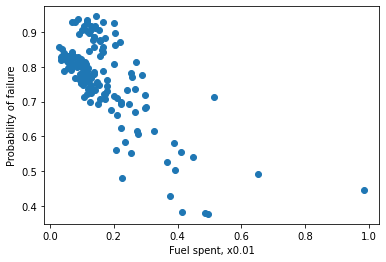

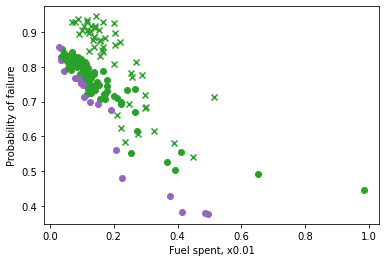

In [11]:
all_query_points = result.datasets[FAILURE].query_points
objective_model_values, _ = result.models[OBJECTIVE].predict(all_query_points)
failure_model_values, _ = result.models[FAILURE].predict_y(all_query_points)

plt.scatter(objective_model_values, 1-failure_model_values);
plt.xlabel("Fuel spent, x0.01");
plt.ylabel("Probability of failure");
plt.show();

points_in_objective_space = tf.concat([objective_model_values, 1-failure_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points)
plt.xlabel("Fuel spent, x0.01");
plt.ylabel("Probability of failure");
plt.show();

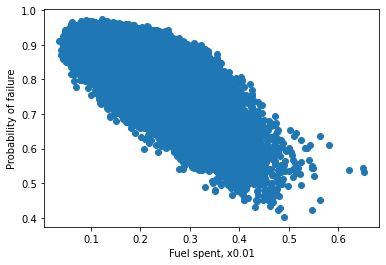

In [12]:
many_random_points = search_space.sample(100000)
objective_model_values, _ = result.models[OBJECTIVE].predict(many_random_points)
failure_model_values, _ = result.models[FAILURE].predict_y(many_random_points)

plt.scatter(objective_model_values, 1-failure_model_values)
plt.xlabel("Fuel spent, x0.01")
plt.ylabel("Probability of failure");
plt.show();

# this fails with OOM because of how non-dominated is implemented in Trieste
# we may want to optimize it for large volumes
# points_in_objective_space = tf.concat([objective_model_values, 1-failure_model_values], axis=1)
# plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=0)
# plt.xlabel("Fuel spent, x0.01")
# plt.ylabel("Probability of failure");
# plt.show();

In [13]:
result.models[OBJECTIVE]._model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,LogNormal,True,(),float64,0.08421791020123497
GPR.kernel.lengthscales,Parameter,Softplus,LogNormal,True,"(12,)",float64,"[0.28382272, 0.34592647, 0.34917076..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0999939869708563e-06
GPR.data[0],ResourceVariable,,,False,"(None, 12)",float64,"[[3.71422259e-01, 1.11496808e+00, 4.68079477e-01..."
GPR.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[0.3021...


In [14]:
result.models[OBJECTIVE]._model.kernel.lengthscales

<Parameter: dtype=float64, shape=[12], fn="softplus", numpy=
array([0.28382272, 0.34592647, 0.34917076, 0.32478705, 0.29559835,
       0.33213554, 0.24839789, 0.23701176, 0.2140719 , 0.24999743,
       0.15606402, 0.17896821])>

In [15]:
result.models[FAILURE]._model

name,class,transform,prior,trainable,shape,dtype,value
VGPWrapper.kernel.variance,Parameter,Softplus,,True,(),float64,1.2779691635099961
VGPWrapper.kernel.lengthscales,Parameter,Softplus,,True,"(12,)",float64,"[0.35979579, 0.3444674, 0.35711195..."
VGPWrapper.data[0],ResourceVariable,,,False,"(None, 12)",float64,"[[0.31455759, 0.86499649, 0.21841858..."
VGPWrapper.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[0....
VGPWrapper.q_mu,Parameter,Identity,,True,"(150, 1)",float64,[[-1.7162463...
VGPWrapper.q_sqrt,Parameter,FillTriangular,,True,"(1, 150, 150)",float64,"[[[7.62265866e-01, 0.00000000e+00, 0.00000000e+00..."
VGPWrapper._num_data,ResourceVariable,,,False,(),float64,150.0


In [16]:
result.models[FAILURE]._model.kernel.lengthscales

<Parameter: dtype=float64, shape=[12], fn="softplus", numpy=
array([0.35979579, 0.3444674 , 0.35711195, 0.37747693, 0.38767163,
       0.31322002, 0.29581362, 0.35474902, 0.36266218, 0.34015958,
       0.33408897, 0.34781179])>

In [17]:
def probability_of_failure(point, n_tries=100):
    if not isinstance(point, np.ndarray):
        point = point.numpy()

    assert point.shape == (int(search_space.dimension),)

    n_failures = 0
    for _ in range(n_tries):
        result = demo_heuristic_lander(lunar_lander.LunarLander(), point, print_result=False)
        if result.timeout or result.has_crashed:
            n_failures += 1
    
    return n_failures / n_tries

In [18]:
all_query_points = result.datasets[FAILURE].query_points
objective_model_values, _ = result.models[OBJECTIVE].predict(all_query_points)
failure_model_values, _ = result.models[FAILURE].predict_y(all_query_points)

In [19]:
pf_points, _ = non_dominated(tf.concat([objective_model_values, 1-failure_model_values], axis=1))
pf_input_points = []
for pf_point in pf_points:
    pf_input_point = tf.boolean_mask(all_query_points, tf.equal(objective_model_values, pf_point[0])[:,0])
    if len(pf_input_point) > 1:
        pf_input_point = pf_input_point[0:1, :]
    pf_input_points.append(pf_input_point)
pf_input_points = tf.concat(pf_input_points, axis=0)

In [20]:
failure_actual_values = [
    probability_of_failure(p) for p in pf_input_points
]

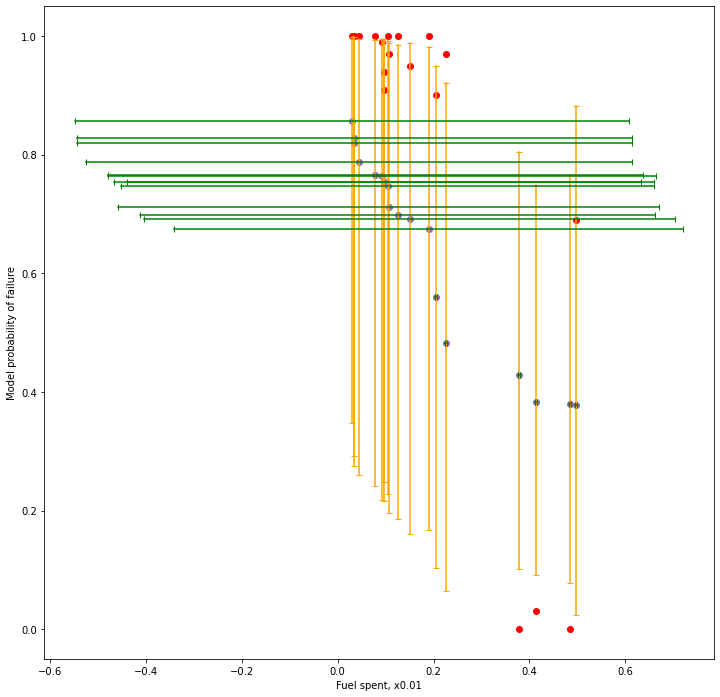

In [21]:
points_in_objective_space = tf.concat([objective_model_values, 1-failure_model_values], axis=1)

mean, variance = result.models[FAILURE].predict(pf_input_points)

# failure_lower_conf_bounds, _ = result.models[FAILURE]._model.likelihood.predict_mean_and_var(
#     mean - 2 * tf.sqrt(variance), variance)
# failure_upper_conf_bounds, _ = result.models[FAILURE]._model.likelihood.predict_mean_and_var(
#     mean + 2 * tf.sqrt(variance), variance)

failure_lower_conf_bounds = result.models[FAILURE]._model.likelihood.invlink(mean - 2 * tf.sqrt(variance))
failure_upper_conf_bounds = result.models[FAILURE]._model.likelihood.invlink(mean + 2 * tf.sqrt(variance))

mean, variance = result.models[OBJECTIVE].predict(pf_input_points)
objective_lower_conf_bounds = mean - 2 * tf.sqrt(variance)
objective_upper_conf_bounds = mean + 2 * tf.sqrt(variance)

plotting.plot_mobo_points_in_obj_space(
    points_in_objective_space,
    num_init=num_initial_points,
    only_plot_pareto=True,
    figsize=(12,12)
)
plt.scatter(pf_points[:, 0], failure_actual_values, c='r')

for i, (lower, upper) in enumerate(zip(1-failure_lower_conf_bounds, 1-failure_upper_conf_bounds)):
    plt.plot((pf_points[i].numpy()[0], pf_points[i].numpy()[0]), (lower,upper), '_-',color='orange')

for i, (lower, upper) in enumerate(zip(objective_lower_conf_bounds, objective_upper_conf_bounds)):
    plt.plot((lower,upper), (pf_points[i].numpy()[1], pf_points[i].numpy()[1]), '|-',color='green')


plt.xlabel("Fuel spent, x0.01")
plt.ylabel("Model probability of failure");
plt.show();